## Import packages

In [1]:
import os

import numpy as np
import random
import librosa.display
import tensorflow_io as tfio
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPool2D
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from helperFunctions import create_dataset_df
import matplotlib.pyplot as plt

## Import dataset metadata

In [2]:
dataset_df = create_dataset_df('UrbanSound8K/metadata/UrbanSound8K.csv')
dataset_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio\fold5\100032-3-0-0.wav
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio\fold5\100263-2-0-117.wav
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio\fold5\100263-2-0-121.wav
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio\fold5\100263-2-0-126.wav
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio\fold5\100263-2-0-137.wav


## Feature Extraction and Data Augmentation functions
When analyzing the data, we found that our dataset contains different sampling frequencies, length, mono / stereo, etc.
In order to classify the data using their spectrogram, we must unify them so that they have the same sampling frequency, length and number of channels.<br>

We will be using Mel-spectrogram for audio classification. If we were classifying speech and not general sounds, we would probably use MFCCs, which generally perform better in these kinds of tasks.
Created spectrum is already one-sided, so we don´t need to cut of second half because of duplicate information.
By default used window is *Hann Window*, and we will keep it this way.<br>

Regarding augmentation, we will apply time shift, time masking and freq masking, which should help with generalization of the model

In [3]:
CLASSES = 10
SAMPLE_RATE = 22050 #Hz
DURATION = 4 #s
N_FFT = 1024
HOP_LENGTH = 256
N_MELS = 64
TIME_BINS =  np.ceil(DURATION*SAMPLE_RATE/N_FFT*(N_FFT/HOP_LENGTH)).astype('int')
TIME_SHIFT_LIMIT = 0.5
TIME_MASKING_PARAM = np.round(TIME_BINS*0.1) # Up to 10% of time can be masked out
FREQ_MASKING_PARAM = np.round(N_MELS*0.1) # Up to 10% of Freqs can be masked out

def processing(filepath, class_id, augment=False):
    # Load audio as mono and resampled
    audio, sample_rate = librosa.load(filepath.numpy(),
                                      sr=SAMPLE_RATE,
                                      mono=True)

    # Make sure every signal has desired length
    audio = librosa.util.fix_length(audio,
                                    size= DURATION * SAMPLE_RATE)

    # Shift data by random amount to the right/left
    if augment:
        audio = time_shift(audio,
                            shift_limit=TIME_SHIFT_LIMIT)

    # Convert to freq domain. -> Mel Spectrum
    spec = mel_dB_spectrum(audio,
                                sr=SAMPLE_RATE,
                                n_fft=N_FFT,
                                hop_length=HOP_LENGTH,
                                n_mels=N_MELS)
    # Add Time and Freq masking
    if augment:
        spec = tfio.audio.freq_mask(np.transpose(spec), param=FREQ_MASKING_PARAM)
        spec = np.transpose(tfio.audio.time_mask(spec, param=TIME_MASKING_PARAM))

    x = np.reshape(spec, (N_MELS, TIME_BINS, 1))
    y = to_categorical(class_id, CLASSES)
    return x, y

def time_shift(audio, shift_limit):
    audio_len = audio.shape[0]
    shift_percentage = random.uniform(-1, 1) * shift_limit
    shift_amt = int(shift_percentage * audio_len)
    return np.roll(audio, shift_amt)

def mel_dB_spectrum(audio, sr, n_fft, hop_length, n_mels):
    mel = librosa.feature.melspectrogram(y=audio,
                                          sr=sr,
                                          n_fft=n_fft,
                                          hop_length=hop_length,
                                          n_mels=n_mels)
    return librosa.power_to_db(np.abs(mel))

def fixup_shape(data, labels):
    data.set_shape([N_MELS, TIME_BINS, 1])
    labels.set_shape([CLASSES])
    return data, labels

## Model Architecture
Regarding model architecture I wanted to try design it myself in order get practical experience with model structures and effect of its parameters.

In [5]:
def create_model(features_size):
    model = Sequential()

    model.add(Conv2D(filters=32,
                    kernel_size=(3,3),
                    padding='valid',
                    input_shape=features_size,
                    activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=32,
                  kernel_size=(3,3),
                  padding='valid',
                  activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64,
                  kernel_size=(3,3),
                  padding='valid',
                  activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64,
                  kernel_size=(3,3),
                  padding='same',
                  activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate= 0.001)

    model.compile(optimizer, loss='categorical_crossentropy', metrics=["accuracy"])
    return model

In [6]:
model = create_model((N_MELS, TIME_BINS, 1))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 343, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 171, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 169, 32)       9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 84, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 84, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 82, 64)        1

## Dataset split

We should use Kfold cross validation, but as part of speeding up and demonstrating the principle, we will do it as follows:

- For training we will use folds 1-9
- For validating we will use fold 10


In [7]:
BATCH_SIZE = 32

### Training Dataset

In [8]:
def create_training_dataset(dataframe):
    return  tf.data.Dataset.from_tensor_slices((dataframe["filepath"], dataframe["classID"]))\
                    .map(lambda filepath, class_id: tf.py_function(processing,
                                                  inp=[filepath, class_id, True],
                                                  Tout=[tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.AUTOTUNE)\
                    .map(fixup_shape,
                          num_parallel_calls=tf.data.AUTOTUNE)\
                    .batch(BATCH_SIZE)\
                    .prefetch(tf.data.AUTOTUNE)\
                    .shuffle(len(dataframe)//BATCH_SIZE)\
                    .repeat()

In [9]:
train_df = dataset_df.loc[dataset_df["fold"] < 10]

train_dataset = create_training_dataset(train_df)

### Augmented data example

       slice_file_name    fsID  start  end  salience  fold  classID     class  \
2310  155314-3-0-5.wav  155314    2.5  6.5         1     7        3  dog_bark   

                                       filepath  
2310  UrbanSound8K/audio\fold7\155314-3-0-5.wav  


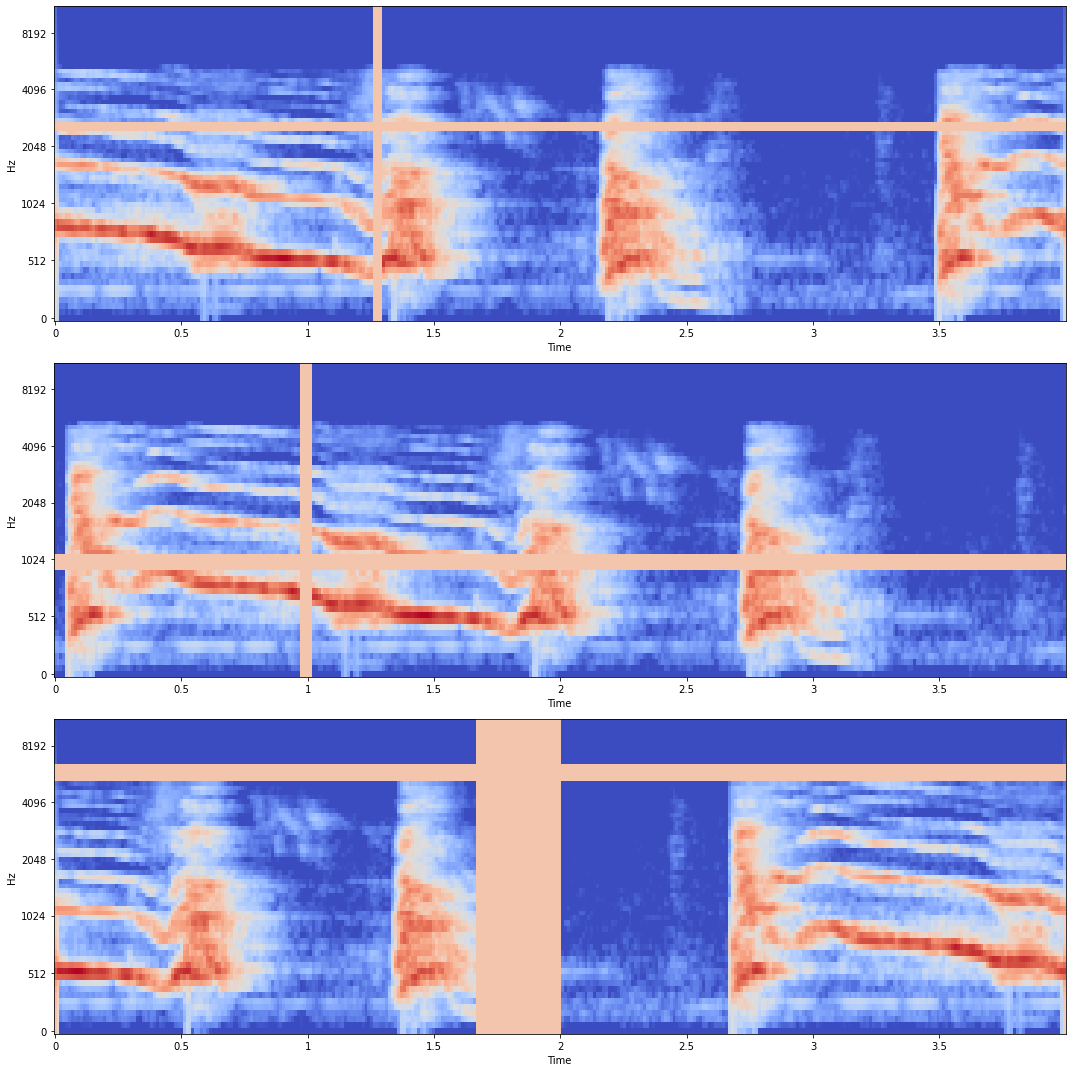

In [10]:
df = train_df.sample(1)
print(df)
#Create dataset, this will return object of TensorSliceDataset
dataset = tf.data.Dataset.from_tensor_slices((df["filepath"], df["classID"]))\
                    .map(lambda filepath, class_id: tf.py_function(processing,
                                                  inp=[filepath, class_id, True],
                                                  Tout=[tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.AUTOTUNE)\
                    .map(fixup_shape,
                          num_parallel_calls=tf.data.AUTOTUNE)\
                    .repeat()\
                    .cache()\
                    .prefetch(tf.data.AUTOTUNE)\


# Visualize the Mel-Spectograms
fig, axs = plt.subplots(3, figsize=(15,15))
row = 0
for data, label in dataset:
        data = np.reshape(data.numpy(),(N_MELS, TIME_BINS))
        spec = librosa.display.specshow(data,
                                        sr=SAMPLE_RATE,
                                        hop_length=HOP_LENGTH,
                                        x_axis="time",
                                        y_axis='mel',
                                        ax=axs[row])
        row += 1
        if row == 3:
            break

fig.tight_layout()

### Validation Dataset

In [11]:
def create_validation_dataset(dataframe):
    return tf.data.Dataset.from_tensor_slices((dataframe["filepath"], dataframe["classID"]))\
                    .map(lambda filepath, class_id: tf.py_function(processing,
                                                  inp=[filepath, class_id],
                                                  Tout=[tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.AUTOTUNE)\
                    .map(fixup_shape,
                          num_parallel_calls=tf.data.AUTOTUNE)\
                    .cache()\
                    .batch(BATCH_SIZE)\
                    .prefetch(tf.data.AUTOTUNE)

In [12]:
valid_df = dataset_df.loc[dataset_df["fold"] == 10]

valid_dataset = create_validation_dataset(valid_df)

## Training

### Model saving

In [13]:
checkpoint_path = "models/acusticEvents-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every epoch
model_save_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=len(train_df)//BATCH_SIZE)

### Clean training

In [14]:
history = model.fit(train_dataset,
              validation_data=valid_dataset,
              validation_steps=len(valid_df)//BATCH_SIZE,
              steps_per_epoch=len(train_df)//BATCH_SIZE,
              epochs=40,
              callbacks=[model_save_callback])

Epoch 1/40
245/246 [============================>.] - ETA: 1s - loss: 2.5151 - accuracy: 0.1167
Epoch 1: saving model to models\acusticEvents-0001.ckpt
246/246 [==============================] - 797s 2s/step - loss: 2.5139 - accuracy: 0.1180 - val_loss: 2.2776 - val_accuracy: 0.1142
Epoch 2/40
245/246 [============================>.] - ETA: 1s - loss: 2.2728 - accuracy: 0.1265
Epoch 2: saving model to models\acusticEvents-0002.ckpt
246/246 [==============================] - 416s 2s/step - loss: 2.2726 - accuracy: 0.1262 - val_loss: 2.2298 - val_accuracy: 0.1406
Epoch 3/40
245/246 [============================>.] - ETA: 1s - loss: 2.1672 - accuracy: 0.1923
Epoch 3: saving model to models\acusticEvents-0003.ckpt
246/246 [==============================] - 415s 2s/step - loss: 2.1666 - accuracy: 0.1925 - val_loss: 2.0741 - val_accuracy: 0.2981
Epoch 4/40
245/246 [============================>.] - ETA: 1s - loss: 2.0303 - accuracy: 0.2536
Epoch 4: saving model to models\acusticEvents-0004.c

### Training from checkpoint

In [15]:
model.load_weights('models/acusticEvents-0040.ckpt')
history = model.fit(train_dataset,
          validation_data=valid_dataset,
          validation_steps=len(valid_df)//BATCH_SIZE,
          steps_per_epoch=len(train_df)//BATCH_SIZE,
          epochs=100,
          callbacks=[model_save_callback])

Epoch 1/100
245/246 [============================>.] - ETA: 1s - loss: 0.6108 - accuracy: 0.7820
Epoch 1: saving model to models\acusticEvents-0001.ckpt
246/246 [==============================] - 757s 2s/step - loss: 0.6110 - accuracy: 0.7820 - val_loss: 1.0708 - val_accuracy: 0.6983
Epoch 2/100
245/246 [============================>.] - ETA: 1s - loss: 0.5709 - accuracy: 0.8036
Epoch 2: saving model to models\acusticEvents-0002.ckpt
246/246 [==============================] - 400s 2s/step - loss: 0.5716 - accuracy: 0.8034 - val_loss: 1.0592 - val_accuracy: 0.6803
Epoch 3/100
245/246 [============================>.] - ETA: 1s - loss: 0.6143 - accuracy: 0.7953
Epoch 3: saving model to models\acusticEvents-0003.ckpt
246/246 [==============================] - 406s 2s/step - loss: 0.6145 - accuracy: 0.7951 - val_loss: 1.1980 - val_accuracy: 0.6815
Epoch 4/100
245/246 [============================>.] - ETA: 1s - loss: 0.5514 - accuracy: 0.8104
Epoch 4: saving model to models\acusticEvents-00

## Evalution

### Accuracy
As we can see our best accuracy is 75,5% on validation dataset that we achieved in epoch 43. Which is not bad considering complexity of the dataset.
On training data we had about 86% in same epoch. From that point model improved up to 92% on training dataset, but did not improved a bit on validation dataset. So it clearly started to overfit on training data.
I also tried different models and augmenation settings but result were pretty much always under 80%. So in order to improve accuracy I would suggest to use some verified models and add/modify features such as mfcc.

In [ ]:
results = []
for i in range(1,100):
    model.load_weights(f'models/acusticEvents-{i:04d}.ckpt')
    print(f"Model-epoch:{i:04d}")
    temp_result = model.evaluate(valid_dataset)
    results.append(temp_result)

In [39]:
res = np.array(results)
print(f"Best model result is {np.max(res[:,1])} in epoch {np.argmax(res[:,1]) + 1}")

Best model result is 0.7550776600837708 in epoch 43


### Confusion matrix
From the Confusion matrix we can see following:
- Every gun shot was accurately recognized.
- In 21% it predicted 'street music' as 'car horn', which did not surprise me because some recordings of 'car horn' contains the sound of the street (including music)
- On the other hand accuracy of siren is pretty stunning to me because I supposed that this one will be easiest to recognize alongside with gun shot.
- In almost 30% it identifies siren as 'children playing' and in 13% it is identified as 'drilling'.

27/27 [==============================] - 2s 55ms/step


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

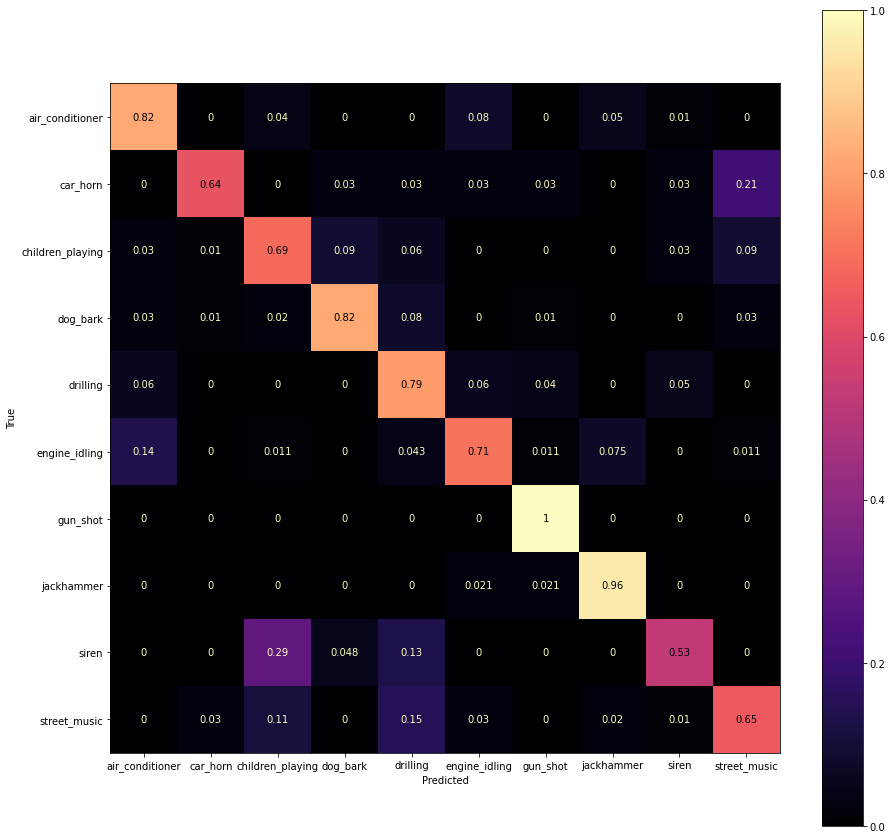

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model.load_weights(f'models/acusticEvents-0043.ckpt')
true_categories = valid_df["classID"]
cat_labels = valid_df.sort_values("classID")["class"].unique()
#Predict
y_prediction = model.predict(valid_dataset)
predicted_categories = tf.argmax(y_prediction, axis=1)

#Create confusion matrix and normalizes it over predicted (columns)
fig, ax = plt.subplots(figsize=(15,15))
cm = confusion_matrix(true_categories, predicted_categories , normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=cat_labels)
cmd.plot(ax=ax, cmap="magma")
cmd.ax_.set(xlabel='Predicted', ylabel='True')